In [1]:
%load_ext autoreload
%autoreload 2

from test_repo_biometric import *
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_curve, auc

In [2]:
# get the file names
train_files, test_files = train_test_all_ids('/data/home/shruti/voxceleb/vgg/leaders/')

# we need control over how much effect the context of the videos 
# and how much data we need to make fabnet behavior work

# this can be done only for obama (or few people with videos in different context)
# control to test on random videos and add the number of videos of obama on the fly..


In [3]:
# get obama_interview_files
# interface to test obama files with only N number of train videos in the repo
# then use the entire obama data to 

In [4]:

# create a train repo with all the original people
def get_train_repo_bo(params):
    
    out_repo = {}
    # leaders
    out_repo = build_repo(params['bsfldr'], 
                      {f: train_files[f] for f in ['br','bs','cb','dt','ew','hc','jb','kh', 'pb',
                                                  'bo_imposter','bs_imposter','ew_imposter','dt_imposter',
                                                   'hc_imposter', 'jb_imposter']}, 
                      {'frames': params['frames'], 'step': params['steps'], 'pool_func': np.mean, 
                       'N': 5000, 'n1':0, 'n2':1}, 
                      in_dict=out_repo)
    
    
    # ff original
    out_repo = build_repo(params['bsfldr'], 
                  {'FF_{0:03d}'.format(f): train_files['FF_{0:03d}'.format(f)] for f in range(1000)}, 
                  {'frames': params['frames'], 'step': params['steps'], 'pool_func': np.mean, 
                   'N': 5000, 'n1':0, 'n2':0.5}, 
                  in_dict=out_repo)

    # Google 
    out_repo = build_repo(params['bsfldr'], 
                  {'GG_{0:02d}'.format(f+1): train_files['GG_{0:02d}'.format(f+1)] for f in range(28)}, 
                  {'frames': params['frames'], 'step': params['steps'], 'pool_func': np.mean, 
                   'N': 5000, 'n1':0, 'n2':1}, 
                  in_dict=out_repo)

    return out_repo


In [10]:

def get_result_df_bo(in_train_repo, params, bo_test_files):
    
    out_result_df = {}
    for r_or_f in ['real', 'fake']:

        r_or_f_res = {}
        
        for ids in bo_test_files:
            cur_test = {}
            cur_test = build_repo(params['bsfldr'], 
                                  {ids: test_files[r_or_f][ids]}, 
                                  {'frames': params['frames'], 'step': params['steps'], 
                                   'pool_func': np.mean, 'N': 5000, 
                                   'n1':0.5 if 'FF_' in ids else 0, 'n2':1}, 
                                  in_dict=cur_test)

            cur_max, cur_pred_id = get_repo_dist(in_train_repo, cur_test[ids])
            r_or_f_res[ids] = pd.DataFrame(data=cur_max, columns=['dist'])
            r_or_f_res[ids]['predLabel'] = cur_pred_id
            r_or_f_res[ids]['actualLabel'] = ids
            r_or_f_res[ids]['RealFake'] = r_or_f

        out_result_df[r_or_f] = pd.concat([r_or_f_res[f] for f in ['bo']], ignore_index=True, sort=False)

    return pd.concat([out_result_df[f] for f in ['real', 'fake']], ignore_index=True, sort=False)


In [21]:
def get_result_rndm_files(in_train_repo, params, bo_test_files, real_fake):
    
    cur_test = {}
    cur_test = build_repo(params['bsfldr'], 
                          {'bo': bo_test_files}, 
                          {'frames': params['frames'], 'step': params['steps'], 
                           'pool_func': np.mean, 'N': 5000, 
                           'n1':0, 'n2':1}, 
                          in_dict=cur_test)

    cur_max, cur_pred_id = get_repo_dist(in_train_repo, cur_test['bo'])
    out_result_df = pd.DataFrame(data=cur_max, columns=['dist'])
    out_result_df['predLabel'] = cur_pred_id
    out_result_df['actualLabel'] = 'bo'
    out_result_df['RealFake'] = real_fake

    return out_result_df


In [7]:

def get_discrepany_accuracy(df1, df2, real_nm, fake_nm):
    
    out_result = np.zeros((2,)) # true positive vs true negatives
    
    # real accuracy df1
    for k in real_nm:
        
        cur_df1 = df1[(df1['actualLabel']==k) & (df1['RealFake']=='real')]
        cur_df2 = df2[(df2['actualLabel']==k) & (df2['RealFake']=='real')]
        n = np.min([len(cur_df1), len(cur_df2)])
        cur_df1 = cur_df1.iloc[:n, :].copy()
        cur_df2 = cur_df2.iloc[:n, :].copy()
        
        # real prediction count
        out_result[0] = len(np.argwhere((np.array(cur_df1['predLabel']) == np.array(cur_df1['actualLabel']))
                    & (np.array(cur_df2['predLabel']) == np.array(cur_df2['actualLabel']))).ravel())*100/n
    
    for k in fake_nm:
        
        cur_df1 = df1[(df1['actualLabel']==k) & (df1['RealFake']=='fake')]
        cur_df2 = df2[(df2['actualLabel']==k) & (df2['RealFake']=='fake')]
        n = np.min([len(cur_df1), len(cur_df2)])
        cur_df1 = cur_df1.iloc[:n, :].copy()
        cur_df2 = cur_df2.iloc[:n, :].copy()
        
        # real prediction count
        out_result[1] = len(np.argwhere((np.array(cur_df1['predLabel']) != np.array(cur_df1['actualLabel']))
                    | (np.array(cur_df2['predLabel']) != np.array(cur_df2['actualLabel']))).ravel())*100/n
            
    return out_result


# VGG + Fabnet Metric

In [25]:
Ns = range(1, 5000, 200)
N_result = np.zeros((len(Ns), 3)) # N, real acc, fake acc

fabnet_repo = get_train_repo_bo({'istrain':True, 'bsfldr':'/data/home/shruti/voxceleb/fabnet_metric/', 
                              'frames':1, 'steps':1})
vgg_repo = get_train_repo_bo({'istrain':True, 'bsfldr':'/data/home/shruti/voxceleb/vgg/leaders/', 
                              'frames':100, 'steps':5})

In [26]:

for i in range(len(Ns)):
    
    # get bo files
    vgg_repo = build_repo('/data/home/shruti/voxceleb/vgg/leaders/', 
                          {f: train_files[f] for f in ['bo']}, 
                          {'frames': 100, 'step': 5, 'pool_func': np.mean, 
                           'N': Ns[i], 'n1':0, 'n2':1}, 
                          in_dict=vgg_repo)
    fabnet_repo = build_repo('/data/home/shruti/voxceleb/fabnet_metric/', 
                          {f: train_files[f] for f in ['bo']}, 
                          {'frames': 1, 'step': 1, 'pool_func': np.mean, 
                           'N': Ns[i], 'n1':0, 'n2':1}, 
                             in_dict=fabnet_repo)
    print('vgg', len(vgg_repo['bo']), 'fabnet', len(fabnet_repo['bo']))

    vgg_result = get_result_df_bo(vgg_repo, {'istrain':True, 'bsfldr':'/data/home/shruti/voxceleb/vgg/leaders/', 
                                             'frames':100, 'steps':5}, ['bo'])
    fabnet_result = get_result_df_bo(fabnet_repo, {'istrain':False, 'bsfldr':'/data/home/shruti/voxceleb/fabnet_metric/', 
                                                   'frames':1, 'steps':1}, ['bo'])
    N_result[i, 0] = Ns[i]
    N_result[i, 1:3] = get_discrepany_accuracy(vgg_result, fabnet_result, ['bo'], ['bo'])
    print(Ns[i], N_result[i, 1:3])
    

vgg 1 fabnet 1
1 [  3.94 100.  ]
vgg 201 fabnet 201
201 [ 96.3 100. ]
vgg 401 fabnet 401
601 [ 98.84 100.  ]
vgg 801 fabnet 801
801 [ 99.02 100.  ]
vgg 1001 fabnet 1001
1001 [ 99.2 100. ]
vgg 1201 fabnet 1201
1201 [ 99.32 100.  ]
vgg 1401 fabnet 1401
1401 [ 99.4 100. ]
vgg 1601 fabnet 1601
1601 [ 99.54 100.  ]
vgg 1801 fabnet 1801
1801 [ 99.54 100.  ]
vgg 2001 fabnet 2001
2001 [ 99.56 100.  ]
vgg 2201 fabnet 2201
2201 [ 99.68 100.  ]
vgg 2401 fabnet 2401
2401 [ 99.7 100. ]
vgg 2601 fabnet 2601
2601 [ 99.7 100. ]
vgg 2801 fabnet 2801


KeyboardInterrupt: 

Text(0.5, 0, 'Samples')

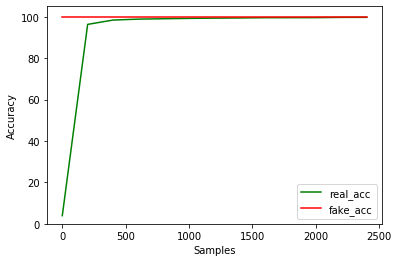

In [29]:
# plot accuracy as a fucntion of file length
plt.figure(figsize=())
plt.plot(N_result[:13, 0], N_result[:13, 1], 'g-', label='real_acc')
plt.plot(N_result[:13, 0], N_result[:13, 2], 'r-', label='fake_acc')
plt.ylim([0, 105])
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Samples')

# test different context files

#### get interview videos

In [17]:

# bo_interview files
bo_interview_files = load_file_names('/data/home/shruti/voxceleb/vgg/leaders/', 'bo_interview', join_bsfldr=False)
bo_interview_files.sort()

# train bo_interview and test bo_interview
n1 = int(0.8*len(bo_interview_files))
train_bo_int_files = bo_interview_files[:n1]
test_bo_int_files = bo_interview_files[n1:]


#### test with mismatch in the repo

In [22]:
# test on the interview videos as test right away

# get bo files
vgg_repo = build_repo('/data/home/shruti/voxceleb/vgg/leaders/', 
                      {f: train_files[f] for f in ['bo']}, 
                      {'frames': 100, 'step': 5, 'pool_func': np.mean, 
                       'N': 5000, 'n1':0, 'n2':1}, 
                      in_dict=vgg_repo)
fabnet_repo = build_repo('/data/home/shruti/voxceleb/fabnet_metric/', 
                      {f: train_files[f] for f in ['bo']}, 
                      {'frames': 1, 'step': 1, 'pool_func': np.mean, 
                       'N': 5000, 'n1':0, 'n2':1}, 
                         in_dict=fabnet_repo)
# test for interview videos
vgg_int_repo_mismatch = {}
vgg_int_repo_mismatch['real'] = get_result_rndm_files(vgg_repo, 
                                              {'istrain':True, 
                                               'bsfldr':'/data/home/shruti/voxceleb/vgg/leaders/', 
                                               'frames':100, 'steps':5}, test_bo_int_files, 'real')
vgg_int_repo_mismatch['fake'] = get_result_rndm_files(vgg_repo, 
                                              {'istrain':True, 
                                               'bsfldr':'/data/home/shruti/voxceleb/vgg/leaders/', 
                                               'frames':100, 'steps':5}, test_files['fake']['bo'], 'fake')
vgg_int_repo_mismatch = pd.concat([vgg_int_repo_mismatch[f] for f in ['real', 'fake']], 
                                  ignore_index=True, sort=False)



# test for interview videos
fabnet_int_repo_mismatch = {}
fabnet_int_repo_mismatch['real'] = get_result_rndm_files(fabnet_repo, 
                                              {'istrain':True, 
                                               'bsfldr':'/data/home/shruti/voxceleb/fabnet_metric/', 
                                               'frames':100, 'steps':5}, test_bo_int_files, 'real')
fabnet_int_repo_mismatch['fake'] = get_result_rndm_files(fabnet_repo, 
                                              {'istrain':True, 
                                               'bsfldr':'/data/home/shruti/voxceleb/fabnet_metric/', 
                                               'frames':1, 'steps':1}, test_files['fake']['bo'], 'fake')
fabnet_int_repo_mismatch = pd.concat([fabnet_int_repo_mismatch[f] for f in ['real', 'fake']], 
                                  ignore_index=True, sort=False)

real_cntxt, fake_cntxt = get_discrepany_accuracy(vgg_int_repo_mismatch, fabnet_int_repo_mismatch, ['bo'], ['bo'])
print(f'Real Interview: {real_cntxt}, Fake Interview: {fake_cntxt}')


Real Interview: 95.59139784946237, Fake Interview: 100.0


#### test with interview videos in the repo

In [23]:

# then add 80% files in the train repo and then run the same test
bo_wd = np.random.choice(train_files['bo'], len(train_bo_int_files), replace=False)
diff_bo_cntxt = {'bo': list(bo_wd) + train_bo_int_files}


In [24]:

vgg_repo = build_repo('/data/home/shruti/voxceleb/vgg/leaders/', 
                      diff_bo_cntxt, 
                      {'frames': 100, 'step': 5, 'pool_func': np.mean, 
                       'N': 5000, 'n1':0, 'n2':1}, 
                      in_dict=vgg_repo)
fabnet_repo = build_repo('/data/home/shruti/voxceleb/fabnet_metric/', 
                      diff_bo_cntxt, 
                      {'frames': 1, 'step': 1, 'pool_func': np.mean, 
                       'N': 5000, 'n1':0, 'n2':1}, 
                         in_dict=fabnet_repo)
# test for interview videos
vgg_interview_repo = {}
vgg_interview_repo['real'] = get_result_rndm_files(vgg_repo, 
                                              {'istrain':True, 
                                               'bsfldr':'/data/home/shruti/voxceleb/vgg/leaders/', 
                                               'frames':100, 'steps':5}, test_bo_int_files, 'real')
vgg_interview_repo['fake'] = get_result_rndm_files(vgg_repo, 
                                              {'istrain':True, 
                                               'bsfldr':'/data/home/shruti/voxceleb/vgg/leaders/', 
                                               'frames':100, 'steps':5}, test_files['fake']['bo'], 'fake')
vgg_interview_repo = pd.concat([vgg_interview_repo[f] for f in ['real', 'fake']], 
                                  ignore_index=True, sort=False)



# test for interview videos
fabnet_interview_repo = {}
fabnet_interview_repo['real'] = get_result_rndm_files(fabnet_repo, 
                                              {'istrain':True, 
                                               'bsfldr':'/data/home/shruti/voxceleb/fabnet_metric/', 
                                               'frames':100, 'steps':5}, test_bo_int_files, 'real')
fabnet_interview_repo['fake'] = get_result_rndm_files(fabnet_repo, 
                                              {'istrain':True, 
                                               'bsfldr':'/data/home/shruti/voxceleb/fabnet_metric/', 
                                               'frames':1, 'steps':1}, test_files['fake']['bo'], 'fake')
fabnet_interview_repo = pd.concat([fabnet_interview_repo[f] for f in ['real', 'fake']], 
                                      ignore_index=True, sort=False)

real_cntxt_intrain, fake_cntxt_intrain = get_discrepany_accuracy(vgg_interview_repo, 
                                                                 fabnet_interview_repo, 
                                                                 ['bo'], ['bo'])
print(f'Real Interview: {real_cntxt_intrain}, Fake Interview: {fake_cntxt_intrain}')


Real Interview: 99.24731182795699, Fake Interview: 100.0


# The distance as function of context

In [32]:

# find an example video we want to find.. 
# in the example 100 frames: 
    # extract the fabnet, 
    # extract the fabnet metric, and 
    # find the best match in the train repo
# for every train video in fabnet metric we need to know the timestamp it is....
# 

# take distances from a single video to show how fabnet biomtric identifies the person

# bsfldr
bsfldr = '/data/home/shruti/voxceleb/fabnet_metric/'
train_vid_name = 'GG_orig/01__outside_talking_still_laughing.npy'
test_vid_label = ['actual faceswap', 
                  'same context same person', 
                  'different context same person',
                  'very different context same person',
                  'different person same context', 
                  'different person different context']
test_vid_name = ['GG_fake/01_02__outside_talking_still_laughing__YVGY8LOK.npy', 
                 'GG_orig/01__outside_talking_pan_laughing.npy', 
                 'GG_orig/01__podium_speech_happy.npy',
                 'GG_orig/01__talking_against_wall.npy', 
                 'GG_orig/02__outside_talking_still_laughing.npy', 
                 'GG_orig/02__talking_against_wall.npy']

# get the distance



In [33]:
# train repo
train_repo = {}
train_repo = build_repo(bsfldr, 
                        {'orig': [train_vid_name]}, 
                        {'frames': 1, 'step': 1, 'pool_func': np.mean, 
                         'N': -1, 'n1':0, 'n2':1}, 
                        in_dict=train_repo)

dist = {}
for i in range(len(test_vid_name)):
    
    test_repo = {}
    test_repo = build_repo(bsfldr, 
                           {'test': [test_vid_name[i]]}, 
                           {'frames': 1, 'step': 1, 'pool_func': np.mean, 
                            'N': -1, 'n1':0, 'n2':1}, 
                           in_dict=test_repo)
    cur_max, cur_pred_id = get_repo_dist(train_repo, test_repo['test'])
    dist[test_vid_label[i]] = cur_max
    

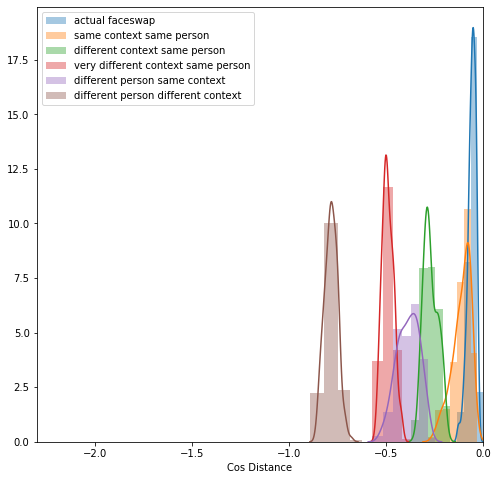

In [37]:
plt.figure(figsize=(8,8))
for i in range(len(test_vid_name)):
    
    sns.distplot(np.log(dist[test_vid_label[i]]), 
                 bins=np.log(np.linspace(0.1, 1, 30)), label=test_vid_label[i])

plt.xlim([np.log(0.1), np.log(1)])    
plt.legend()
plt.xlabel('Cos Distance')
plt.show()

# find the example video getting matched with a video

In [11]:
# select a file of obama 4 seconds with saying "hello everybody"
test_files = 'bo/_zq8ilzRFFE_0.npy'
bsfldr = '/data/home/shruti/voxceleb/fabnet_metric/'
bo_train_files = train_files['bo']
bo_train_files = [f for f in bo_train_files if f != test_files]
bo_train_files.sort()

test_repo = {}
test_repo = build_repo(bsfldr, 
                        {'bo': [test_files]}, 
                        {'frames': 1, 'step': 1, 'pool_func': np.mean, 
                         'N': -1, 'n1':0, 'n2':1}, 
                        in_dict=test_repo)


max_sim = np.zeros((len(test_repo['bo']), )) - np.inf
ids = np.zeros((len(test_repo['bo']), )) - 1
file_nm = np.array([' ' for i in range(len(test_repo['bo']), ) ], dtype=np.object)

for i in range(len(bo_train_files)):
    
    train_repo = {}
    train_repo = build_repo(bsfldr, 
                        {'bo': [bo_train_files[i]]}, 
                        {'frames': 1, 'step': 1, 'pool_func': np.mean, 
                         'N': -1, 'n1':0, 'n2':1}, 
                        in_dict=train_repo)
    if len(train_repo['bo']) > 1:
        sim_mat = cosine_similarity(train_repo['bo'], test_repo['bo'], dense_output=True)
        
        max_id = np.argmax(sim_mat, axis=0)
        sim_mat = np.max(sim_mat, axis=0)
        chng_id = sim_mat>max_sim
        ids[chng_id] = max_id[chng_id]
        file_nm[chng_id] = bo_train_files[i]
        max_sim[chng_id] = sim_mat[chng_id]
        

In [12]:
file_nm

array(['bo/li1aHjjqh3w_0.npy', 'bo/0bB0Cv4Oz0I_0.npy',
       'bo/0bB0Cv4Oz0I_0.npy', 'bo/_zq8ilzRFFE_1.npy',
       'bo/_zq8ilzRFFE_1.npy', 'bo/_zq8ilzRFFE_1.npy',
       'bo/_zq8ilzRFFE_1.npy', 'bo/0bB0Cv4Oz0I_0.npy',
       'bo/_zq8ilzRFFE_2.npy', 'bo/_zq8ilzRFFE_2.npy',
       'bo/_zq8ilzRFFE_2.npy', 'bo/_zq8ilzRFFE_2.npy',
       'bo/_zq8ilzRFFE_2.npy', 'bo/_zq8ilzRFFE_2.npy',
       'bo/_zq8ilzRFFE_1.npy', 'bo/_zq8ilzRFFE_2.npy',
       'bo/_zq8ilzRFFE_2.npy', 'bo/_zq8ilzRFFE_2.npy',
       'bo/_zq8ilzRFFE_2.npy', 'bo/_zq8ilzRFFE_2.npy',
       'bo/_zq8ilzRFFE_2.npy', 'bo/_zq8ilzRFFE_1.npy',
       'bo/_zq8ilzRFFE_2.npy', 'bo/_zq8ilzRFFE_2.npy',
       'bo/_zq8ilzRFFE_2.npy', 'bo/_zq8ilzRFFE_2.npy',
       'bo/_zq8ilzRFFE_2.npy', 'bo/_zq8ilzRFFE_1.npy',
       'bo/_zq8ilzRFFE_1.npy', 'bo/_zq8ilzRFFE_1.npy',
       'bo/_zq8ilzRFFE_1.npy', 'bo/_zq8ilzRFFE_1.npy',
       'bo/_zq8ilzRFFE_1.npy', 'bo/_zq8ilzRFFE_2.npy',
       'bo/_zq8ilzRFFE_1.npy', 'bo/_zq8ilzRFFE_1.npy',
       'bo

In [38]:
i = 1
print(max_sim[i], file_nm[i], ids[i]*5/30)


0.9298540513752178 bo/0bB0Cv4Oz0I_0.npy 15.666666666666666


In [29]:
ids[3]

96.0

In [26]:

94*5/30

15.666666666666666